In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
import argparse
import cv2
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--epoch", type=int, default=0, help="Epoch to start training from")
parser.add_argument("--n_epoch", type=int, default=1, help="total number of epochs for training")
parser.add_argument("--batch_size", type=int, default=3, help="Size of batches")
parser.add_argument("--lr", type=float, default=0.0002, help="Learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="Decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="Decay of second order momentum of gradient")
parser.add_argument("--decay_epoch", type=int, default=100, help="Epoch from which to start lr decay")
parser.add_argument("--n_cpu", type=int, default=8, help="Number of cpu threads to use during batch generation")
parser.add_argument("--hr_height", type=int, default=512, help="High res. image height")
parser.add_argument("--hr_width", type=int, default=512, help="High res. image width")
parser.add_argument("--channels", type=int, default=3, help="Number of image channels")
parser.add_argument("--sample_interval", type=int, default=1000, help="Interval between saving image samples")
parser.add_argument("--checkpoint_interval", type=int, default=5000, help="Batch interval between model checkpoints")
parser.add_argument("--residual_blocks", type=int, default=15, help="Number of residual blocks in the generator")
parser.add_argument("--warmup_batches", type=int, default=500, help="Number of batches with pixel-wise loss only")
parser.add_argument("--lambda_adv", type=float, default=5e-3, help="Adversarial loss weight")
parser.add_argument("--lambda_pixel", type=float, default=1e-2, help="Pixel-wise loss weight")
opt = parser.parse_args(args=[])
opt

Namespace(b1=0.9, b2=0.999, batch_size=3, channels=3, checkpoint_interval=5000, decay_epoch=100, epoch=0, hr_height=512, hr_width=512, lambda_adv=0.005, lambda_pixel=0.01, lr=0.0002, n_cpu=8, n_epoch=1, residual_blocks=15, sample_interval=1000, warmup_batches=500)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
## VGG 19 feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg19_54 = nn.Sequential(*list(vgg19_model.features.children())[:35])

    def forward(self, img):
        return self.vgg19_54(img)

In [5]:
class DenseResidualBlock(nn.Module):
    """
    The core module of paper: (Residual Dense Network for Image Super-Resolution, CVPR 18)
    """

    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [nn.Conv2d(in_features, filters, 3, 1, 1, bias=True)]
            if non_linearity:
                layers += [nn.LeakyReLU()]
            return nn.Sequential(*layers)

        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x

In [6]:
class ResInResDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResInResDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)
        )
        
    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

In [7]:
class GeneratorRRDB(nn.Module):
    def __init__(self, channels, filters=64, num_res_blocks=16, num_upsample=2):
        super(GeneratorRRDB, self).__init__()

        # First layer
        self.conv1 = nn.Conv2d(channels, filters, kernel_size=3, stride=1, padding=1)
        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResInResDenseBlock(filters) for _ in range(num_res_blocks)])
        # Second conv layer post residual blocks
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)
        # Upsampling layers
        upsample_layers = []
        for _ in range(num_upsample):
            upsample_layers += [
                nn.Conv2d(filters, filters * 4, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(),
                nn.PixelShuffle(upscale_factor=2),
            ]
        self.upsampling = nn.Sequential(*upsample_layers)
        # Final output block
        self.conv3 = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(filters, channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

In [8]:
gen_chkt_pth = '/kaggle/input/esrgan-checkpoints/generator_0_5000.pth'

In [9]:
generator = GeneratorRRDB(opt.channels, filters=64, num_res_blocks=opt.residual_blocks).to(device)

In [10]:
generator.load_state_dict(torch.load(gen_chkt_pth, map_location=torch.device(device)))
generator.eval()
print("Model Loaded")

Model Loaded


In [11]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [13]:
img = cv2.imread('/kaggle/input/esrgan-checkpoints/patch_000025122.jpg')
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [14]:
img_transformed = transform(img)
img_transformed = img_transformed.unsqueeze(0)

In [15]:
def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return torch.clamp(tensors, 0, 255)

In [16]:
output = generator(img_transformed)
output.size()

torch.Size([1, 3, 512, 512])

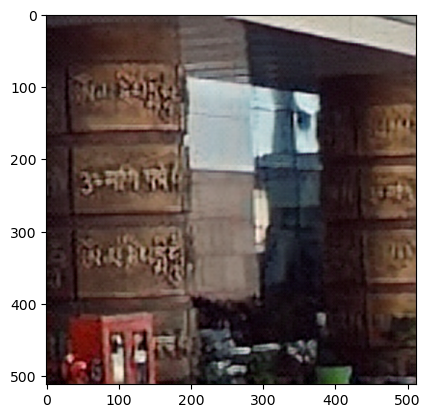

In [17]:
with torch.no_grad():
    generator.eval()
    gen_hr = generator(img_transformed)
    img_grid = denormalize(gen_hr)
    plt.imshow(img_grid.squeeze(0).permute(1,2,0))
    save_image(img_grid, "predicted.png", nrow=1, normalize=False)

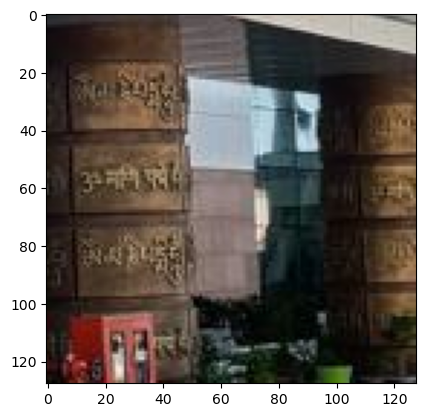

In [18]:
plt.imshow(img)